# Optical Velocimeter

### Define the Model

##### Initialisation of SymPy

In [1]:
import sympy as sym
from IPython.display import display, Math 

# Init Printing
sym.init_printing()

def func(name: str, f: sym.core, simplify: bool = False):
    display(sym.Eq(sym.symbols(name), sym.Eq(f, sym.simplify(f), evaluate=False) if simplify else f, evaluate=False))
    return f

##### Define the Parameters

In [2]:
f1, f2, vAuto, alpha = sym.symbols('f_1 f_2 v_{auto} \\alpha')
s, c = sym.symbols('s c', constant=True)


##### Define the Equations

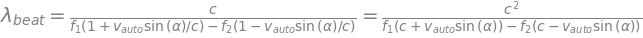

<IPython.core.display.Math object>

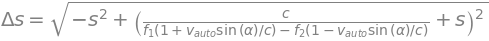

In [3]:
# Relative Velocity
vRel = func('v_{rel}', vAuto * sym.sin(alpha))

# Doppler Shift
f1Doppler = func('\hat{f_1}', f1 * (1 + vRel / c))
f2Doppler = func('\hat{f_2}', f2 * (1 - vRel / c))

# Beat Frequency and Wavelength
fBeat = func('f_{beat}', f1Doppler - f2Doppler, simplify=True)
lambdaBeat = func('\lambda_{beat}', c / fBeat, simplify=True)

# Delta S
display(Math('\Delta s = \\sqrt{\\left(s + \\lambda_{beat}\\right)^{2} - s^{2}}\\quad\\Rightarrow'))
deltaS = func('\Delta{}s', sym.sqrt((s + lambdaBeat)**2 - s**2))


##### Create Sliders for the Parameters

/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


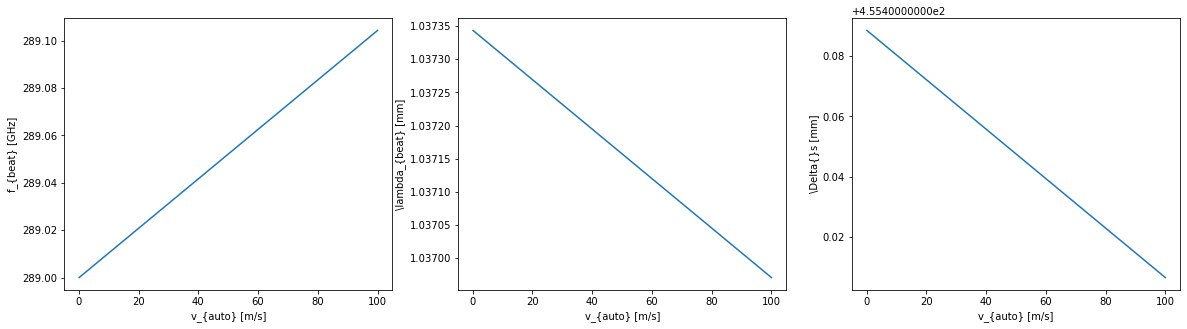

In [70]:
from matplotlib import pyplot as plt
from scipy.optimize import fsolve
import numpy as np

from ipywidgets import interactive, fixed

def plot(_fBase, _fOffset, _alpha, _s):
    _alpha = np.deg2rad(_alpha)
    _c = 299792458
    
    _fBeat = lambda _vAuto : sym.lambdify((f1, f2, vAuto, alpha, c), fBeat, 'numpy')(_fBase, _fBase - _fOffset, _vAuto, _alpha, _c)
    _lambdaBeat = lambda _vAuto : sym.lambdify((f1, f2, vAuto, alpha, c), lambdaBeat, 'numpy')(_fBase, _fBase - _fOffset, _vAuto, _alpha, _c)
    _deltaS = lambda _vAuto : sym.lambdify((f1, f2, vAuto, alpha, c, s), deltaS, 'numpy')(_fBase, _fBase - _fOffset, _vAuto, _alpha, _c, _s)
    
    _maximumSpeed = 100
    _minimumSpeed = fsolve(lambda _vAuto : _deltaS(_vAuto) * 1e3 - _s * np.tan(_alpha), 100)[0]
    if _minimumSpeed > _maximumSpeed:
        _minimumSpeed = 0.1
    _vAutoArray = np.linspace(0.1, 100, 1000)
    
    fig = plt.figure(figsize=(20, 5))
    ax = fig.add_subplot(1, 3, 1)
    ax.plot(_vAutoArray, _fBeat(_vAutoArray) / 1e9)
    ax.set_xlabel('v_{auto} [m/s]')
    ax.set_ylabel('f_{beat} [GHz]')
    
    cut = 0
    ax = fig.add_subplot(1, 3, 2)
    ax.plot(_vAutoArray[cut:], _lambdaBeat(_vAutoArray[cut:]) * 1e3)
    ax.set_xlabel('v_{auto} [m/s]')
    ax.set_ylabel('\lambda_{beat} [mm]')
    
    
    ax = fig.add_subplot(1, 3, 3)
    ax.plot(_vAutoArray[cut:], _deltaS(_vAutoArray[cut:]) * 1e3)
    ax.set_xlabel('v_{auto} [m/s]')
    ax.set_ylabel('\Delta{}s [mm]')
    
plot(9e14, 2.89e11, 10, 100)